# Определение возраста покупателей

Нужно построить модель машинного обученя, которая будет определять возраст посетителя. 

## Загрузка

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

загрузили библиотеки

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


загрузили данные

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично. Данные загружены.
</div>

## Исследовательский анализ данных

In [3]:
print(labels.info())
print(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


В датасете 7591 фотография, что не так много, но достаточно для обучения нейронной сетью

In [4]:
labels.isna().mean()

file_name    0.0
real_age     0.0
dtype: float64

Пропусков нет

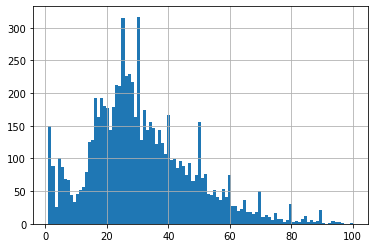

In [5]:
labels['real_age'].hist(bins = 100)

Очевидно, что по большей части возраст сосредоточен около 25 лет, есть много младенческих (много фотографий годовалых, в целом до 5 лет), а также и людей постарше (до 100 лет). Достаточно много неожиданных пиков, посмотрим поближе в числовом формате.

In [16]:
labels['real_age'].value_counts(sort = True).head(15)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
Name: real_age, dtype: int64

При более подробном рассмотрении видны пики около "нулевых" значений (30, 40, 50 и тд) возможно оценка производилась наугад/округленно.

<div class="alert alert-warning">
<b>Комментарий от ревьюера</b>

Корзин маловато. У нас возраст от 1 до 100, значит и корзин желательно 100 чтобы увидеть особенности распределения и потом в выводе его правильно описать. При 50 тоже видно, но так явно.
</div>

**Комментарий: Почему-то не догадался про сотню, на 50 увидел и решил да вроде норм :) добавил**

<div class="alert alert-success">
<b>Комментарий ревьюера 2</b>

👍
</div>

In [6]:
features, target = next(train_gen_flow)

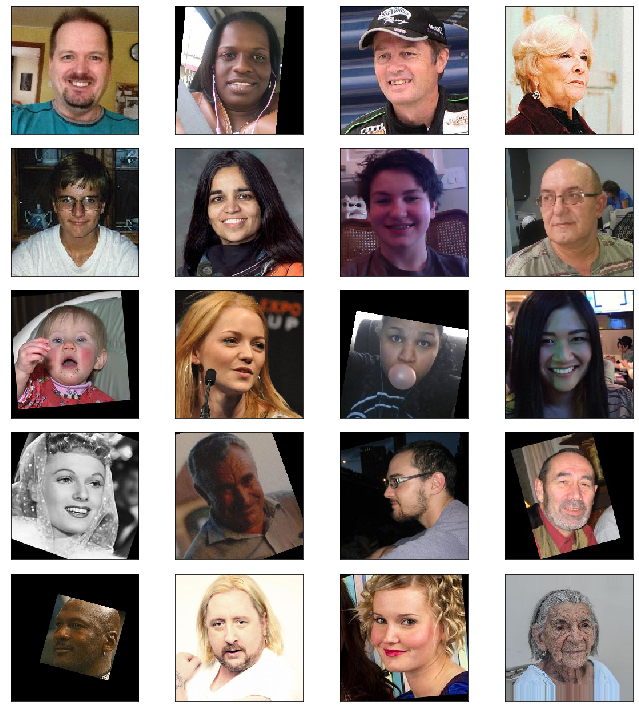

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Хорошо, что 20 фото и в несколько рядов. Видны главные особенности.
</div>

По сэмплу видно, что фотография не стандартизированы. В глаза бросается сразу много проблем:
- повернутые фотографии
- фото в полоборота
- фото разных размеров (с закрашенным задником)
- фото разного качества (пиксельные) и контрастности
- фото с помехами (вроде микрофонов, жвачки и тд)
- лица занимают разный размер от фото (модель может пытаться предсказывать по фону)

<div class="alert alert-danger">
<b>Комментарий от ревьюера</b>

По результатам анализа датасета, гистограммы и фото необходимы следующие уточнения:

1. Пояснения по размеру выборки (большая, маленькая, достаточная) и предложения по работе с датасетом такого размера.
2. Выводы по гистограмме. Обратить внимание на выбросы, пики в круглые даты и выдвинуть предположения почему они могли появиться.
3. По фото. Помимо углов поворота важно отметить и другие важные особенности особенности увиденные на фото: цветность, качество, размер лиц и т.п. и предложить аугментацию (при необходимости).
<br/>
</div>

**Вывод по Исследовательскому анализу:** 
1. Выборка не очень большая, особенно учитывая не однообразность фотографий и широкое распределение по возрасту (поскольку мы предсказываем не промежутки, а конкретный возраст). Важно также, что для нейронной сети выборка достаточна для обучения.
2. По возрасту выборка сосредоточена около 25 лет, но также есть и довольно много младенческих фото (до 5 лет), а также и дилнный хвост фото людей в возрасте (до 100 лет). Кроме этого есть пики около десятков - возможно оценка производилась примерно (кажется около 30 лет - ставим 30) - это может повлиять на точность предсказаний!
3. Фото в выборке представлены весьма разнообразные, с разными настройкаи качества и контрастности, поворота фотографий и поворота лиц, с помехами (лишними предметами) и разных размеров лицами. Это всё оже может ухудшить качество предсказаний

По аргументам выше можно точно заявить, что задача для обучения весьма сложная. В идеале конечно же еще загрузить размеченные фото и как-то их стандартизировать, чтобы точнось была лучше. Однако загрузить фото не имеется возможности, а стандартизация сделает задачу синтетической/оторванной от реальности. В связи с этим выходом может быть аугментация обучающего набора данных (фото со сдвигами, отражения, добавления шумов, изенения яркости и насыщенности), что сделает обучения модели более качественным. Однако это может слишком "утяжелить" обучение модели. Для нашего случае вользём горизонтальное отражение (horizontal_flip).

<div class="alert alert-success">
<b>Комментарий ревьюера 2</b>

Отличный вывод! Верно, что пики – это округления! Также важно отметить наличие ч/б фото (не повезло, что в выборку из 20 фото ни одного не попало :) )
</div>

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape= input_shape,
        weights='imagenet', 
        include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr = 0.0001)
    model.compile(
        loss='mean_squared_error', 
        optimizer=optimizer, metrics=['mae']
    )
 
    return model 


def train_model(
    model, train_data, test_data, 
    epochs=5,
    steps_per_epoch=None, 
    validation_steps=None,
    batch_size = None):
  
    if steps_per_epoch==None:
        steps_per_epoch=len(train_data)
    if validation_steps==None:
        validation_steps=len(test_data)
 
    model.fit(
        train_data, 
        validation_data=(test_data), 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch, 
        batch_size=batch_size,
        validation_steps=validation_steps, 
        verbose=2,
        shuffle=True
    )
    return model 

```

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично, что используется аугментация horizontal_flip. Другие примеры можно посмотреть в <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator">документации</a> или в <a href="https://towardsdatascience.com/machinex-image-data-augmentation-using-keras-b459ef87cd22">статье</a>.
</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера</b>

Добавлены 2 слоя: со 100 нейронами и с 10. Интересно для чего? Как их добавление повлияло или должно было повлиять на рузультат? У нас задача регресии и в целом одного нейрона на выходе достаточно.
</div>

**Комментарий: Добавлял их в предыдущих, улучало модель (может совпадало), поэтому здесь следовал этой же логике. Запросы долго обрабатываются, поэтому без не тестил**

<div class="alert alert-success">
<b>Комментарий ревьюера 2</b>

Скорее всего на результат это никак не повлияет, однако, лучше посмотреть с ними и без.
</div>

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/5
356/356 - 118s - loss: 217.9289 - mae: 10.6771 - val_loss: 469.6405 - val_mae: 16.4343
Epoch 2/5
356/356 - 39s - loss: 84.3596 - mae: 6.9361 - val_loss: 118.2650 - val_mae: 8.1400
Epoch 3/5
356/356 - 39s - loss: 55.5434 - mae: 5.7102 - val_loss: 76.4553 - val_mae: 6.5273
Epoch 4/5
356/356 - 39s - loss: 39.9177 - mae: 4.8164 - val_loss: 75.1235 - val_mae: 6.4130
Epoch 5/5
356/356 - 39s - loss: 30.1077 - mae: 4.1675 - val_loss: 75.4946 - val_mae: 6.5567

119/119 - 10s - loss: 75.4946 - mae: 6.5567
Test MAE: 6.5567
```

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Неплохой результат для 5 эпох.
</div>

## Анализ обученной модели

Модель сверточной нейронной сети построена на ResNet50.

Обученная модель позволяет с высокой точностью предсказывать возраст покупателей. Как мы видим, на последней эпохе модель хоть и улучшила MAE на обучающей выборке, на тестовой уже не стало лучше (риск переобучения). 

Итоговая ошибка на тестовой выборке всего лишь 6,5 лет что не так уж и много (но конечно нужно учитывать чувствительные к ошибке методы применения, например для оценки совершеннолетия).

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отличный подробный вывод. Хорошо, что отмечена склонность модели к переобучению.
</div>

<div class="alert alert-info">
<b>Итоговый комментарий ревьюера</b>

Отличный проект. Осталось только добавить вывод по 1 разделу. Буду ждать новую версию.
<hr>
</div>

<div class="alert alert-info">
<b>Итоговый комментарий ревьюера 2</b>

Дмитрий, спасибо за подробные дополнения и понятные ответы. Поздравляю с успешной подготовкой проекта. Данная тема достаточно обширная для одного спринта. Перед нами стояла задача понять основы для более глубокого погружения. Рекомендую ознакомиться с фреймворком <a href="https://pytorch.org/">PyTorch</a>. Желаю успехов в финальном спринте и профессии!

<hr>
</div>

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы